In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import time
from scipy.stats import randint, uniform
import random
import keras
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from tensorflow.keras import layers, Model, Input
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker
from matplotlib.colors import LinearSegmentedColormap
import shap


2025-08-26 01:18:44.016890: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 01:18:44.289158: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-26 01:18:44.289482: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-26 01:18:44.291366: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-26 01:18:44.437259: I tensorflow/core/platform/cpu_feature_g

In [2]:
tf.__version__

'2.14.0'

In [3]:
def check_left(genes, current_idx, threshold):
    # check left neighbors
    left_neighbor_idx = [current_idx]
    for i in range(current_idx-1, -1, -1):
        if genes[current_idx][0] - genes[i][1] <= threshold:
            left_neighbor_idx.append(i)
        else:
            break
    return left_neighbor_idx

def check_right(genes, current_idx, threshold):
    right_neighbor_idx = [current_idx]
    for i in range(current_idx+1, len(genes)):
        if genes[i][0] - genes[current_idx][1] <= threshold:
            right_neighbor_idx.append(i)
        else:
            break
    return right_neighbor_idx

# generate the gene set we want
def get_sets(genes, threshold):
    sets = []
    for i in range(len(genes)):
        left_set = check_left(genes, i, threshold)
        right_set = check_right(genes, i, threshold)
        current_set = sorted(list(set(left_set + right_set)))
        sets.append(current_set)

    return sets


def avg_dst2(get_to, genes, s):
    dcts = []
    # get_to contains the gene set idx
    for path_idx in get_to:
        #print( f'-->path (set index) {path_idx}')
        covered = set()
        dst_dict = {}
        # path contains the actual idx of the gene
        path = [s[p] for p in path_idx]
        #print(f'    -->expanded path {path}')
        for idx, p in enumerate(path):
            #print(f'        current gene set {p}, center gene is {path_idx[idx]}')
            # get center element
            center_idx = p.index(path_idx[idx])
            # if current set contains overlapping elements
            if not set(p) & set(covered):
                for j, gene_idx in enumerate(p):
                    if j != center_idx:
                        dst = (
                            genes[p[center_idx]][0] - genes[gene_idx][1]
                            if j < center_idx
                            else genes[gene_idx][0] - genes[p[center_idx]][1]
                        )
                        # overlap or inclusive
                        dst_dict[gene_idx] = max(0, dst)
                covered.update(p)
            else:
                # if current set contains overlapping elements
                for j, gene_idx in enumerate(p):
                    if j != center_idx:
                        dst = (
                            genes[p[center_idx]][0] - genes[gene_idx][1]
                            if j < center_idx
                            else genes[gene_idx][0] - genes[p[center_idx]][1]
                        )
                        dst = max(0, dst)
                        if gene_idx not in dst_dict or dst < dst_dict[gene_idx]:
                            dst_dict[gene_idx] = dst
                covered.update(p)
        # calculate avg distance
        if dst_dict:
            dsts = sum(list(dst_dict.values()))
            avgs = dsts / len(dst_dict)
            dcts.append(avgs)
        # if single element
        else:
            dcts.append(0)
    #print(dcts)
    # get all min elements
    min_idx = [i for i,x in enumerate(dcts) if x == min(dcts)]
    res = [get_to[i] for i in min_idx]
    return res

def check_overlap(get_to, gene_set):
    #find which path contains the least amount of genes
    overlap_counter = [[], float('inf')]
    no_overlap_get_to = []
    for i in range(len(get_to)):
        lst = []
        for j in get_to[i]:
            lst += gene_set[j]
        # no overlap
        #print(lst)
        if len(lst) == len(set(lst)):
            no_overlap_get_to.append(get_to[i])
        else:
            if abs(len(lst) - len(set(lst))) < overlap_counter[1]:
                overlap_counter[0] += (get_to[i])
                overlap_counter[1] = abs(len(lst) - len(set(lst)))
    if len(no_overlap_get_to) != 0:
        return no_overlap_get_to
    else:
        #print(overlap_counter)
        return [overlap_counter[0]]


# this will produce the minimal gene sets that covers the genome
def solve_gene(gene_set, genes, protein2):
    #start_time = time.time()
    # the start state is the first gene
    # 1st idx: the current gene idx (starting at 0-th gene)
    # 2nd idx: path that gets to the current gene. since we will begin at the first gene (for i in range(1,...)), the path that get to the first gene is the 0-th gene.
    # 3rd idx: max() indicates the rightmost gene in the current gene's neighborhood
    # 4th idx: the number of solves needed. Since we start at 0-th gene, we need to solve it.
    states = [0,[[0]],max(gene_set[0]),1]
    #print(states)
    #prev_set = []
    # since 0-th gene is already solved, we begin at the 1st gene.
    #start_time = time.time()
    for i in range(1, len(gene_set)):
        #print(f' i = {i}')
        
        #print(gene_set[i])
        #if gene_set[i] == prev_set:
            #continue
        
        # flag indicate when we need to increment the amount of solves
        increase_solve = False
        # what genes (path) that can get to the current gene
        get_to = []
        # check what genes can get to the previous gene and use that to start, DP
        for j in states[1]:
            #print(f'j = {j}')
            # keeps a record of the path that gets to the previous gene. when starting, 0-th gene can get to 0-th gene.
            prev_path = j.copy()
            # since the path that gets to the previous gene is already recorded, when moving on to the next gene,
            # we need to add the previous gene to the previous path, so it becomes the path that gets to the current_gene.
            prev_path.append(states[0])
            #print(f'prev_path after appending previous gene {prev_path}')
            # these are the new paths that can get to the current gene
            # since there might be repetitive paths, use set.
            get_to.append(sorted(list(set(prev_path))))
            # check overlap sets or direct next set
            if (gene_set[i][0] <= gene_set[j[-1]][-1] <= gene_set[i][-1]) or (gene_set[i][0] == gene_set[j[-1]][-1] + 1): 
                get_to.append(j.copy())
                #print(f'get to after appending duplicate {get_to}')
            # if previous gene's set is a subset of the current, then previous and current are parallel solution
            if set(gene_set[j[-1]]).issubset(gene_set[i]) and gene_set[i][0] == gene_set[0][0]:
                # since previous can get to current, parallel solution added
                get_to.append([i])
                # parallel solution, no need to increase the number of solves
                increase_solve = True
                #print(f'get to after appending parallel {get_to}')

            # eliminate duplicates
            unique_set = {tuple(element) for element in get_to}
            get_to = sorted([list(element) for element in unique_set])

            # only keep the least amount of solves, this is the objective of DP
            min_length = min(len(i) for i in get_to)
            get_to = [i for i in get_to if len(i) == min_length]

            # if competing solution exist, use min_avg dst to break ties
            #reduced_get_to = check_overlap(get_to, gene_set)
            #reduced_get_to = cal_avg_dst(get_to, genes)
            get_to = avg_dst2(get_to, genes, gene_set)
            #print(f'reduced get to {reduced_get_to}')

            # if parallel solution found, the number of solves is equal to previous number of solves
            if increase_solve:
                current_solves = states[-1]
            # if no parallel solution, add 1 to previous number of solves
            else:
                current_solves = min([len(i) for i in get_to])+1

        # track prev set to determine if completely identical set
        #prev_set = gene_set[i]
        
        #print(len(get_to))
        #print(f'get to is {get_to}')
        #print(f'took {end_time-start_time}s')

        # update the state 
        states = [i, get_to, max(gene_set[i]), current_solves]
        # reset the parallel solution counter
        increase_solve = False
        #print(f'current state {states}')
        
    #print(states)

    solution = []
    #final_states = states[1].copy()
    for i in states[1]:
        #print(i)
        # if solution covers to the end
        if gene_set[i[-1]][-1] != states[2]:
            i.append(states[0])
        
        else:
            i.append(gene_set[-1][-1])

        # check if optimal solution
        if len(i) == states[-1]:
            #solution.append(i)
            solution = [list(protein2.keys())[j] for j in i]

    #end_time = time.time()
    #print(end_time-start_time)
    
    return solution
    #print(f'final solution {states}')

In [4]:
def get_ref_for_genome(threshold, all_gene_dict):
    # based on the given threshold, get the reference genes for the whole genome

    # threshold: int
    # all_genes_in_genome: dict, containing all the key,value pairs of genes and their info
    
    # holder for all protein coding genes
    all_reference_genes = []

    # for each chromosome, get all protein coding genes, only for numeric chromosomes, not including X and Y
    for i in range(1,23):

        # isolate the genes (key,value) pairs on each chromosome
        genes_on_current_chrom = {gene_name:gene_info for gene_name,gene_info in all_gene_dict.items() if gene_info[0]==f'chr{i}'}
        
        # get the gene txstart and txend and also its strand
        # p is the gene name, [p][2] is the txstart, [p][3] is the txend
        genes_location = np.array([[genes_on_current_chrom[p][2],genes_on_current_chrom[p][3]] for p in genes_on_current_chrom])
        
        # group the genes into sets based on the threshold.
        gene_sets_on_current_chrom = get_sets(genes_location, threshold)
        #print(f'{len(gene_sets_on_current_chrom)} number of sets before')

        # get the reference genes on the current chromosome
        reference_genes_on_current_chrom = solve_gene(gene_sets_on_current_chrom, genes_location, genes_on_current_chrom)
        #print(f'{len(reference_genes_on_current_chrom)} number of sets after')

        # add the reference genes on the current chromosome to the holder
        all_reference_genes += reference_genes_on_current_chrom
        #print(f'chr{i} done')
    
    # this will return all reference genes (a list of gene NAMES) in the genome from chr1 to chr22.
    return all_reference_genes

In [5]:
def get_reference_gene_df(all_ref_genes, all_gene_dict):
    # since all_ref_genes is a list of gene names, we need to query all_gene_dict to get their info
    # this will return a dataframe containing the reference genes and their info later used for training.

    # holder that we will convert to a DataFrame later
    rows = []

    # iterate through all reference genes by index
    for i in range(len(all_ref_genes) - 1):
        
        # get the current gene's chrom
        current_chrom = all_gene_dict[all_ref_genes[i]][0]

        # get the next gene's chrom
        next_chrom = all_gene_dict[all_ref_genes[i+1]][0]

        # get the current gene's txend
        current_end = all_gene_dict[all_ref_genes[i]][3]

        # get the next gene's txstart
        next_start = all_gene_dict[all_ref_genes[i+1]][2]

        # get the current gene's exp
        current_promoter = all_gene_dict[all_ref_genes[i]][6]

        # get the next gene's exp
        next_promoter = all_gene_dict[all_ref_genes[i+1]][6]

        # get the current gene's exp
        current_exp = all_gene_dict[all_ref_genes[i]][7]

        # get the next gene's exp
        next_exp = all_gene_dict[all_ref_genes[i+1]][7]

        # get the current strand
        current_strand = all_gene_dict[all_ref_genes[i]][1]

        # Map the current strand to an integer
        current_strand = 1 if current_strand == '+' else 0

        # get the next strand
        next_strand = all_gene_dict[all_ref_genes[i+1]][1]
        next_strand = 1 if next_strand == '+' else 0

        # prepare row for the dataset, make sure on the same chrom
        if current_chrom == next_chrom:
            #neighbor_dst = abs(next_start - current_end)
            neighbor_dst = next_start - current_end
            current_row = [all_ref_genes[i], all_ref_genes[i+1], current_strand, next_strand, neighbor_dst, current_promoter, next_promoter, current_exp, next_exp]
            rows.append(current_row)

    # Create a DataFrame from the collected gene dict
    columns = ['current_gene', 'next_gene', 'current_strand', 'neighbor_strand', 'neighbor_dst','current_promoter', 'neighbor_promoter', 'current_exp', 'neighbor_exp']
    raw_training_dict = pd.DataFrame(rows, columns=columns)
    
    return raw_training_dict

In [6]:
def find_closest_ref_gene(a_non_ref_gene_name, all_genes_dict, all_ref_genes):
    # given a non-reference gene name, this function will find its closest reference gene name

    # convert to set for o(1) lookup
    ref_genes_set = set(all_ref_genes)

    # get all the gene names. Note: the names are increasingly ordered in the genome
    all_gene_names = list(all_genes_dict.keys())

    # a dictionary to map gene names to their index
    gene_to_idx = {}
    # iterate through all the gene names 
    for idx, gene in enumerate(all_gene_names):
        # key is the gene name, its index is the value
        gene_to_idx[gene] = idx

    # get the index of the non reference gene in the genome
    idx = gene_to_idx[a_non_ref_gene_name]

    # get the chromosome of the current non reference gene
    current_chrom = all_genes_dict[a_non_ref_gene_name][0]

    # find the previous reference gene
    def find_previous_ref():
        # starting at the gene right before
        for i in range(idx-1, -1, -1):
            # get the gene name
            gene = all_gene_names[i]
            # if this gene is indeed a reference gene
            if gene in ref_genes_set:
                # get its name, chromosome
                return gene, all_genes_dict[gene][0]
        # return None if no reference gene is found
        return None, None
    
    # find the next reference gene
    def find_next_ref():
        # starting at the gene right next
        for i in range(idx+1, len(all_gene_names)):
            # get the gene name
            gene = all_gene_names[i]
            # if this gene is indeed a reference gene
            if gene in ref_genes_set:
                # get its name and chromosome
                return gene, all_genes_dict[gene][0]
        # return None if no reference gene is found
        return None, None

    
    prev_ref, prev_chrom = find_previous_ref()
    next_ref, next_chrom = find_next_ref()

    #Calculate distances for same-chromosome candidates
    candidates = []
    
    if prev_ref and prev_chrom == current_chrom:
        prev_end = all_genes_dict[prev_ref][3]
        curr_start = all_genes_dict[a_non_ref_gene_name][2]
        prev_strand = all_genes_dict[prev_ref][1]
        prev_promoter = all_genes_dict[prev_ref][6]
        prev_exp = all_genes_dict[prev_ref][7]
        # this also includes negative distance
        candidates.append((curr_start - prev_end, prev_ref, prev_strand, prev_promoter, prev_exp))
    
    if next_ref and next_chrom == current_chrom:
        next_start = all_genes_dict[next_ref][2]
        curr_end = all_genes_dict[a_non_ref_gene_name][3]
        next_strand = all_genes_dict[next_ref][1]
        next_promoter = all_genes_dict[next_ref][6]
        next_exp = all_genes_dict[next_ref][7]
        # this also includes negative distance
        candidates.append((next_start - curr_end, next_ref, next_strand, next_promoter, next_exp))

    if not candidates:
        # print(prev_ref, prev_chrom)
        # print(next_ref, next_chrom)
        # print(non_ref_gene, current_chrom)
        return None

    # Return the closest reference gene, dst to it, reference gene's exp and it strand
    dst_to_closest_ref = min(candidates, key=lambda x: abs(x[0]))[0]
    closest_ref_name = min(candidates, key=lambda x: abs(x[0]))[1]
    closest_ref_strand = min(candidates, key=lambda x: abs(x[0]))[2]
    mapped_strand = 1 if closest_ref_strand == '+' else 0
    closest_ref_promoter = min(candidates, key=lambda x: abs(x[0]))[3]
    closest_ref_exp = min(candidates, key=lambda x: abs(x[0]))[4]

    return (dst_to_closest_ref, closest_ref_name, mapped_strand, closest_ref_promoter, closest_ref_exp)

In [7]:
def find_ref_pairs(not_ref_genes, all_genes_dict, all_ref_genes):
    # for each non_ref_genes, this will find the closest reference gene to predict it.

    # using a dict, so each non-reference gene will be mapped to its closest reference gene
    # so the keys can be unique
    reference_genes_pair = {}  

    # iterate over all non reference genes and find their closets neighbor
    for i in not_ref_genes:
        
        # find the closest reference gene to this non-reference gene
        dst, closest_ref_gene, closest_ref_strand, closest_ref_promoter, closest_ref_exp = find_closest_ref_gene(i, all_genes_dict, all_ref_genes)

        # make sure the cloesest ref gene we got is indeed an reference gene
        if closest_ref_gene not in all_ref_genes:
            print('error', i)

        non_ref_gene_strand = all_genes_dict[i][1]
        mapped_non_ref_gene_strand = 1 if non_ref_gene_strand == '+' else 0

        mapped_closest_ref_strand = 1 if closest_ref_strand == '+' else 0
        # add the non-reference gene - reference gene pair to the holder
        reference_genes_pair.update({i: [closest_ref_gene, dst, mapped_non_ref_gene_strand, mapped_closest_ref_strand, closest_ref_promoter, closest_ref_exp]})

    return reference_genes_pair

In [8]:
def get_non_ref_df(reference_genes_pair, not_ref_genes, all_genes_dict):
    rows = []
    for i in not_ref_genes:
        rows.append([i, reference_genes_pair[i][0], reference_genes_pair[i][1], reference_genes_pair[i][2], reference_genes_pair[i][3], reference_genes_pair[i][4], all_genes_dict[i][6], reference_genes_pair[i][5], all_genes_dict[i][7]])
    
    columns = ['non_ref_gene', 'ref_gene', 'neighbor_dst', 'non_ref_strand', 'ref_strand', 'ref_promoter', 'non_ref_promoter', 'ref_exp', 'non_ref_exp']
    non_ref_df = pd.DataFrame(rows, columns=columns)

    return non_ref_df

In [ ]:
# Positional Encoding Layer (Sinusoidal)
@keras.saving.register_keras_serializable()
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.d_model = d_model

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        d_model = self.d_model
        position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(
            tf.range(0, d_model, 2, dtype=tf.float32) *
            (-tf.math.log(10000.0) / d_model)
        )
        angle_rads = position * div_term
        sin_part = tf.sin(angle_rads)
        cos_part = tf.cos(angle_rads)
        pos_encoding = tf.reshape(
            tf.stack([sin_part, cos_part], axis=-1),
            (seq_len, d_model)
        )
        pos_encoding = pos_encoding[tf.newaxis, :, :]
        return inputs + pos_encoding

    def get_config(self):
        config = super().get_config()
        config.update({"d_model": self.d_model})
        return config

@keras.saving.register_keras_serializable()
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x, training=False, return_attention=False):
        attn_output, attn_weights = self.mha(x, x, x, return_attention_scores=True)
        self.attention_scores = attn_weights
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        if return_attention:
            return out2, self.attention_scores  
        return out2

def build_shared_cnn_branch(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(64, 8,  padding='same', activation='relu', name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Dropout(0.4)(x)
    x_residual = layers.Conv1D(64, 1, padding='same', name='residual_conv1')(x)
    x = layers.Add(name='residual1')([x_residual, x])
    x = layers.MaxPooling1D(2)(x)
    
    x = layers.Conv1D(128, 12, padding='same', activation='relu', name='conv2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Dropout(0.4)(x)
    x_residual = layers.Conv1D(128, 1, padding='same', name='residual_conv2')(x)
    x = layers.Add(name='residual2')([x_residual, x])
    x = layers.MaxPooling1D(2)(x)
    
    x = layers.Conv1D(256, 16, padding='same', activation='relu', name='conv3')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.GlobalAveragePooling1D(name='global_pool')(x)
    return models.Model(inputs, x, name='shared_cnn_branch')

def build_promoter_cnn(input_shape=(666, 4), output_dim=128):
    inp1 = Input(shape=input_shape, name='current_promoter')  # Shape: (666, 4)
    inp2 = Input(shape=input_shape, name='neighbor_promoter')  # Shape: (666, 4)

    shared_cnn = build_shared_cnn_branch(input_shape)

    feat1 = shared_cnn(inp1)
    feat2 = shared_cnn(inp2)
    cosine_similarity = layers.Dot(axes=1, normalize=True, name='cosine_similarity')([feat1, feat2])  # Shape: (1,)
    x = layers.Concatenate(name='concat_features')([feat1, feat2, cosine_similarity])  # Shape: (513,)
    x = layers.Dense(output_dim, activation='relu', name='output_dense')(x)
    x = layers.Dropout(0.4)(x)

    return models.Model(inputs=[inp1,inp2], outputs=x, name='promoter_cnn_shared')


# 4. Full model (for supervised training)
def build_full_model(
    exp_input_shape=(54, 1),
    aux_input_shape=(5,),
    #seq_input_shape=(1332, 4),
    seq_input_shape=(666, 4),
    d_model=128, num_heads=8, num_layers=4, dff=None, dropout_rate=0.1,
    promoter_cnn_output_dim=128,
):
    if dff is None:
        dff = d_model * 4
    exp_input = layers.Input(shape=exp_input_shape, name="expression_input")
    aux_input = layers.Input(shape=aux_input_shape, name="aux_input")
    #stacked_promoter_input = layers.Input(shape=seq_input_shape, name="stacked_promoters_input")
    curr_promoter_input = layers.Input(shape=seq_input_shape, name="current_promoter")
    neigh_promoter_input = layers.Input(shape=seq_input_shape, name="neighbor_promoter")

    promoter_cnn = build_promoter_cnn(seq_input_shape, promoter_cnn_output_dim)
    promoter_cnn.summary()
    #promoter_features = promoter_cnn(stacked_promoter_input)
    promoter_features = promoter_cnn([curr_promoter_input, neigh_promoter_input])

    x = layers.Dense(d_model)(exp_input)
    x = PositionalEncoding(d_model)(x)
    for _ in range(num_layers):
        x = TransformerEncoderLayer(d_model, num_heads, dff, dropout_rate)(x)
    transformer_features = layers.GlobalAveragePooling1D()(x)

    all_features = layers.Concatenate()([transformer_features, promoter_features, aux_input])
    outputs = layers.Dense(54, activation='softplus')(all_features)

    model = models.Model(
        #inputs=[exp_input, aux_input, stacked_promoter_input],
        inputs=[exp_input, aux_input, curr_promoter_input, neigh_promoter_input],
        outputs=outputs
    )
    return model

# 5. Feature extractor (for hybrid pipeline)
def build_feature_extractor(
    exp_input_shape=(54, 1),
    aux_input_shape=(5,),
    #seq_input_shape=(1332, 4),
    seq_input_shape=(666, 4),
    d_model=128, num_heads=8, num_layers=4, dff=None, dropout_rate=0.1,
    promoter_cnn_output_dim=128,
):
    if dff is None:
        dff = d_model * 4
    exp_input = layers.Input(shape=exp_input_shape, name="expression_input")
    aux_input = layers.Input(shape=aux_input_shape, name="aux_input")
    #stacked_promoter_input = layers.Input(shape=seq_input_shape, name="stacked_promoters_input")
    curr_promoter_input = layers.Input(shape=seq_input_shape, name="current_promoter")
    neigh_promoter_input = layers.Input(shape=seq_input_shape, name="neighbor_promoter")
    

    promoter_cnn = build_promoter_cnn(seq_input_shape, promoter_cnn_output_dim)
    #promoter_features = promoter_cnn(stacked_promoter_input)
    promoter_features = promoter_cnn([curr_promoter_input, neigh_promoter_input])

    x = layers.Dense(d_model)(exp_input)
    x = PositionalEncoding(d_model)(x)
    for _ in range(num_layers):
        x = TransformerEncoderLayer(d_model, num_heads, dff, dropout_rate)(x)
    transformer_features = layers.GlobalAveragePooling1D()(x)

    all_features = layers.Concatenate()([transformer_features, promoter_features, aux_input])
    model = models.Model(
        #inputs=[exp_input, aux_input, stacked_promoter_input],
        inputs=[exp_input, aux_input, curr_promoter_input, neigh_promoter_input],
        outputs=all_features
    )
    return model


def process_aux_input(X_aux_train):
    # X_aux_train: shape (n_samples, 3) -- [neighbor_dst, current_strand, neighbor_strand]
    aux_preprocessor = ColumnTransformer([
        ('distance', StandardScaler(), [0]),
        ('strand', OneHotEncoder(), [1, 2])
        #('strand', OneHotEncoder(), [1, 2])
    ])
    X_aux_train_proc = aux_preprocessor.fit_transform(X_aux_train)
    return X_aux_train_proc, aux_preprocessor

def process_exp_input(X_exp_train):
    # X_exp_train: shape (n_samples, 54)
    exp_scaler = MinMaxScaler()
    X_exp_train_proc = exp_scaler.fit_transform(X_exp_train)
    return X_exp_train_proc, exp_scaler

def process_targets(y_train):
    y_scaler = MinMaxScaler()
    y_train_proc = y_scaler.fit_transform(y_train)
    return y_train_proc, y_scaler

# ont hot encode the sequences
def one_hot_encode_sequences(seq_list, seq_len=666):
    """Convert list of DNA sequences to one-hot encoded numpy array"""
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    encoded = np.zeros((len(seq_list), seq_len, 4), dtype=np.float32)
    
    for i, seq in enumerate(seq_list):
        seq = seq.upper()
        for j in range(min(len(seq), seq_len)):
            if seq[j] in mapping:
                encoded[i, j, mapping[seq[j]]] = 1.0
    return encoded

def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def train_nn():

    with open('protein2_promoter.pkl', 'rb') as f:
        all_genes_dict = pickle.load(f)

    # # only keep genes on numeric chromosome, not including X and Y
    all_genes_dict = {k: v for k, v in all_genes_dict.items() if v[0] != 'chrX' and v[0] != 'chrY'} 
    # #print(len(all_genes_dict))

    # # holder that holds the avg_error and avg_std at each of the thresholds
    mean_errors = []
    #threshold = [0,100,550,1500,3000,5000,8000,12000,17000,23000]
    #thres = [2500,5000,7500,10000]
    #thres = [i*10000 for i in range(11,21)]
    thres = [2500]
    
    for i in thres:
        print(f'processing threshold {i}')
        all_ref_genes = get_ref_for_genome(i, all_genes_dict)
        not_ref_genes = [gene for gene in all_genes_dict if gene not in all_ref_genes]
        training_df = get_reference_gene_df(all_ref_genes, all_genes_dict)
        ref_gene_pairs = find_ref_pairs(not_ref_genes, all_genes_dict, all_ref_genes)
        testing_df = get_non_ref_df(ref_gene_pairs, not_ref_genes, all_genes_dict)
        
        # Prepare training data
        neighbor_exp_array = np.array(training_df['neighbor_exp'].tolist())  # (n_samples, 54)
        aux_columns = ['neighbor_dst', 'current_strand', 'neighbor_strand']
        #aux_columns = ['current_strand', 'neighbor_strand']
        X_aux = np.stack([np.array([row[col] for col in aux_columns]) for idx, row in training_df.iterrows()])  # (n_samples, 3)
        y = np.array(training_df['current_exp'].tolist())  # (n_samples, 54)
        X_curr_promoter = one_hot_encode_sequences(training_df['current_promoter'].tolist())
        X_neighbor_promoter = one_hot_encode_sequences(training_df['neighbor_promoter'].tolist())
        #X_stacked_promoter = np.concatenate([X_curr_promoter, X_neighbor_promoter], axis=1)  # (n_samples, 1332, 4)

        # Train/Val split
        # X_exp_train, X_exp_val, X_aux_train, X_aux_val, \
        # X_stacked_prom_train, X_stacked_prom_val, \
        # y_train, y_val = train_test_split(
        #     neighbor_exp_array, X_aux, X_stacked_promoter, y, test_size=0.15, random_state=42
        # )
        X_exp_train, X_exp_val, X_aux_train, X_aux_val, \
        X_curr_prom_train, X_curr_prom_val, \
        X_neigh_prom_train, X_neigh_prom_val, \
        y_train, y_val = train_test_split(
            neighbor_exp_array, X_aux, X_curr_promoter, X_neighbor_promoter, y,
            test_size=0.15, random_state=42
        )

        # Preprocessing
        X_exp_train_proc, exp_scaler = process_exp_input(X_exp_train)
        X_aux_train_proc, aux_preprocessor = process_aux_input(X_aux_train)
        print(X_aux_train_proc.shape)
        y_train_proc, y_scaler = process_targets(y_train)
        X_exp_val_proc = exp_scaler.transform(X_exp_val)
        X_aux_val_proc = aux_preprocessor.transform(X_aux_val)
        y_val_proc = y_scaler.transform(y_val)
        X_exp_train_reshaped = X_exp_train_proc[..., np.newaxis]
        X_exp_val_reshaped = X_exp_val_proc[..., np.newaxis]

        # Build & train full neural net model
        full_model = build_full_model(
            exp_input_shape=(54, 1),
            aux_input_shape=(X_aux_train_proc.shape[1],),
            #seq_input_shape=(1332, 4),
            seq_input_shape=(666, 4),
            d_model=128, num_heads=8, num_layers=4, dff=512,
            promoter_cnn_output_dim=128
        )
        full_model.compile(
            optimizer=tf.keras.optimizers.AdamW(
                learning_rate=1e-5,
                weight_decay=1e-5,
                clipnorm=2.0,
                clipvalue=1.0
            ),
            #loss=tf.keras.losses.Huber(delta=0.5),
            loss='mse',
            metrics=['mse','mae']
        )
        # history = full_model.fit(
        #     #[X_exp_train_reshaped, X_aux_train_proc, X_stacked_prom_train], 
        #     [X_exp_train_reshaped, X_aux_train_proc, X_curr_prom_train, X_neigh_prom_train], y_train_proc,
        #     validation_data=([X_exp_val_reshaped, X_aux_val_proc, X_stacked_prom_val], y_val_proc),
        #     epochs=200, batch_size=32, verbose=2,
        #     callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True,min_delta=1e-4)]
        # )
        history = full_model.fit(
            [X_exp_train_reshaped, X_aux_train_proc, X_curr_prom_train, X_neigh_prom_train],
            y_train_proc,
            validation_data=([X_exp_val_reshaped, X_aux_val_proc, X_curr_prom_val, X_neigh_prom_val], y_val_proc),
            epochs=200, batch_size=32, verbose=2,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=30,
                    restore_best_weights=True,
                    min_delta=1e-4
                )
            ]
        )

        # --- SAVE THE TRAINED FULL KERAS MODEL HERE ---
        full_model.save('cnn_encoder.keras')
        # ------------------------------------------------

        # Plot training history
        plot_training_history(history)
        
        # Prepare test data
        aux_columns2 = ['neighbor_dst', 'non_ref_strand', 'ref_strand']
        #aux_columns2 = ['non_ref_strand', 'ref_strand']
        neighbor_exp_test = np.array(testing_df['ref_exp'].tolist())
        X_aux_test = np.stack([np.array([row[col] for col in aux_columns2]) for idx, row in testing_df.iterrows()])
        y_test = np.array(testing_df['non_ref_exp'].tolist())
        X_curr_promoter_test = one_hot_encode_sequences(testing_df['non_ref_promoter'].tolist())
        X_neighbor_promoter_test = one_hot_encode_sequences(testing_df['ref_promoter'].tolist())
        #X_stacked_promoter_test = np.concatenate([X_curr_promoter_test, X_neighbor_promoter_test], axis=1)

        X_exp_test_proc = exp_scaler.transform(neighbor_exp_test)
        X_aux_test_proc = aux_preprocessor.transform(X_aux_test)
        y_test_proc = y_scaler.transform(y_test)
        X_exp_test_reshaped = X_exp_test_proc[..., np.newaxis]

        # Build feature extractor & copy weights
        feature_model = build_feature_extractor(
            exp_input_shape=(54, 1),
            aux_input_shape=(X_aux_train_proc.shape[1],),
            #seq_input_shape=(1332, 4),
            seq_input_shape=(666, 4),
            d_model=128, num_heads=8, num_layers=4, dff=512,
            promoter_cnn_output_dim=128
        )
        for idx, layer in enumerate(feature_model.layers):
            try:
                layer.set_weights(full_model.layers[idx].get_weights())
            except Exception:
                pass

        # Extract features for train/val/test
        # X_train_features = feature_model.predict([X_exp_train_reshaped, X_aux_train_proc, X_stacked_prom_train], batch_size=64)
        # X_val_features   = feature_model.predict([X_exp_val_reshaped, X_aux_val_proc, X_stacked_prom_val], batch_size=64)
        # X_test_features  = feature_model.predict([X_exp_test_reshaped, X_aux_test_proc, X_stacked_promoter_test], batch_size=64)
        # Extract features for train/val/test
        X_train_features = feature_model.predict(
            [X_exp_train_reshaped, X_aux_train_proc, X_curr_prom_train, X_neigh_prom_train],
            batch_size=64
        )
        X_val_features = feature_model.predict(
            [X_exp_val_reshaped, X_aux_val_proc, X_curr_prom_val, X_neigh_prom_val],
            batch_size=64
        )
        X_test_features = feature_model.predict(
            [X_exp_test_reshaped, X_aux_test_proc, X_curr_promoter_test, X_neighbor_promoter_test],
            batch_size=64
        )

        #Train XGBoost
        xgb_base = XGBRegressor(
            objective='reg:squarederror',
            eval_metric='rmse',
            tree_method='hist',
            device='cuda',
            n_jobs=-1,
            verbosity=0,
            n_estimators=750,
            learning_rate=0.005,
            max_depth=5,
            subsample=0.7,
            colsample_bytree=0.8,
            gamma=0.2,
            reg_lambda=5,
            reg_alpha=0.1,
            min_child_weight=10,
            grow_policy='depthwise'
        )

        def make_quantile_model(alpha):
            return MultiOutputRegressor(
                XGBRegressor(
                    objective='reg:quantileerror',
                    tree_method='hist',
                    device='cuda',
                    n_jobs=-1,
                    verbosity=0,
                    n_estimators=750,
                    learning_rate=0.005,
                    max_depth=5,
                    subsample=0.7,
                    colsample_bytree=0.8,
                    gamma=0.2,
                    reg_lambda=5,
                    reg_alpha=0.1,
                    
                    min_child_weight=10,
                    grow_policy='depthwise',
                    quantile_alpha=alpha
                )
        )

        # Train median (already trained)
        multi_output_xgb = MultiOutputRegressor(xgb_base)
        multi_output_xgb.fit(X_train_features, y_train_proc)

        # Train lower 2.5% bound
        lower_model = make_quantile_model(0.95)
        lower_model.fit(X_train_features, y_train_proc)

        # Train upper 97.5% bound
        upper_model = make_quantile_model(0.05)
        upper_model.fit(X_train_features, y_train_proc)

        # Predict and evaluate
        y_pred = multi_output_xgb.predict(X_test_features)
        y_pred_lower = lower_model.predict(X_test_features)
        y_pred_upper = upper_model.predict(X_test_features)


        y_pred_median_real = y_scaler.inverse_transform(y_pred)
        y_pred_lower_real = y_scaler.inverse_transform(y_pred_lower)
        y_pred_upper_real = y_scaler.inverse_transform(y_pred_upper)

        
        pccs = []
        for j in range(y_pred.shape[0]):
            c, _ = pearsonr(np.array(y_pred[j]), np.array(y_test_proc[j]))
            if not np.isnan(c):
                pccs.append(c)
        pccs = np.array(pccs)
        err = 1 - pccs
        print(np.mean(err))
        mean_errors.append(np.mean(err))

    return multi_output_xgb, lower_model, upper_model, mean_errors, X_test_features, aux_preprocessor, X_train_features, y_train_proc, y_pred_median_real, y_pred_lower_real, y_pred_upper_real, testing_df

In [ ]:
best_model, lower_model, upper_model, mean_errors, X_test_features,aux_preprocessor, X_train_features, y_train_proc, y_pred_median_real, y_pred_lower_real, y_pred_upper_real,testing_df = train_nn()

In [ ]:
# Select gene index
def show_random_profile_prediction(gene_idx):

    gene_name = testing_df.iloc[gene_idx]["non_ref_gene"]
    ref_gene_name = testing_df.iloc[gene_idx]["ref_gene"]

    pred = y_pred_median_real[gene_idx, :]
    low = y_pred_lower_real[gene_idx, :]
    high = y_pred_upper_real[gene_idx, :]

    # Extract real expression values
    real_exp = testing_df.iloc[gene_idx]["non_ref_exp"]

    ref_gene_exp= testing_df.iloc[gene_idx]["ref_exp"]

    # Ensure all inputs are NumPy arrays for consistent operations
    pred = np.array(pred)
    low = np.array(low)
    high = np.array(high)
    real_exp = np.array(real_exp)

    pred_min = np.min(pred)
    pred_max = np.max(pred)
    low_min = np.min(low)
    low_max = np.max(low)
    high_min = np.min(high)
    high_max = np.max(high)
    
    # Normalize to [0, 1] range
    if pred_max == pred_min:
        pred = np.zeros_like(pred)
        low = np.zeros_like(low)
        high = np.zeros_like(high)

    else:
        pred = (pred - pred_min) / (pred_max - pred_min)
        low = (low - low_min) / (low_max - low_min)
        high = (high - high_min) / (high_max - high_min)

    # Calculate error bar lengths, ensuring they are non-negative
    lower_err = np.maximum(pred - low, 0)
    upper_err = np.maximum(high - pred, 0)
    total_error = lower_err + upper_err

    # Create tissue indices
    tissues = np.arange(54)

    # Set up figure with two subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), dpi=100, sharey=True)

    # Left panel: Predicted expression with confidence intervals
    ax1.bar(tissues, pred, color='blue', alpha=0.7, zorder=3)
    ax1.errorbar(tissues, pred, yerr=[0.5*total_error, 0.5*total_error], fmt='none', ecolor='black', 
                capsize=3, alpha=0.5, zorder=4)
    ax1.set_xlabel('Tissue Index', fontsize=12)
    ax1.set_ylabel('Normalized TPM', fontsize=12)
    ax1.set_title(f'Predicted Expression for {gene_name} with 90% CI', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.7, zorder=1)
    ax1.legend(fontsize=10)
    ax1.set_xticks(tissues[::5])
    ax1.set_xticklabels(tissues[::5], fontsize=10)
    ax1.set_ylim(0, 1)  # Normalized TPM range [0,1] with padding

    # Right panel: Real expression values
    ax2.bar(tissues, real_exp, color='green', alpha=0.7,  zorder=3)
    ax2.set_xlabel('Tissue Index', fontsize=12)
    ax2.set_title(f'Real Expression Profile for {gene_name}', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.7, zorder=1)
    ax2.legend(fontsize=10)
    ax2.set_xticks(tissues[::5])
    ax2.set_xticklabels(tissues[::5], fontsize=10)

    # Right panel: Real expression values
    ax3.bar(tissues, ref_gene_exp, color='red', alpha=0.7,  zorder=3)
    ax3.set_xlabel('Tissue Index', fontsize=12)
    ax3.set_title(f'Reference gene for {gene_name} is {ref_gene_name}', fontsize=14)
    ax3.grid(True, linestyle='--', alpha=0.7, zorder=1)
    ax3.legend(fontsize=10)
    ax3.set_xticks(tissues[::5])
    ax3.set_xticklabels(tissues[::5], fontsize=10)

    c = pearsonr(pred, real_exp)[0]
    print(f'PCC = {c}')

    # Tight layout for publication
    plt.tight_layout()

    # Save plot (for paper submission)
    plt.show()

/tmp/ipykernel_713/1227893923.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=10)
/tmp/ipykernel_713/1227893923.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=10)
/tmp/ipykernel_713/1227893923.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(fontsize=10)


PCC = 0.4146782135971492


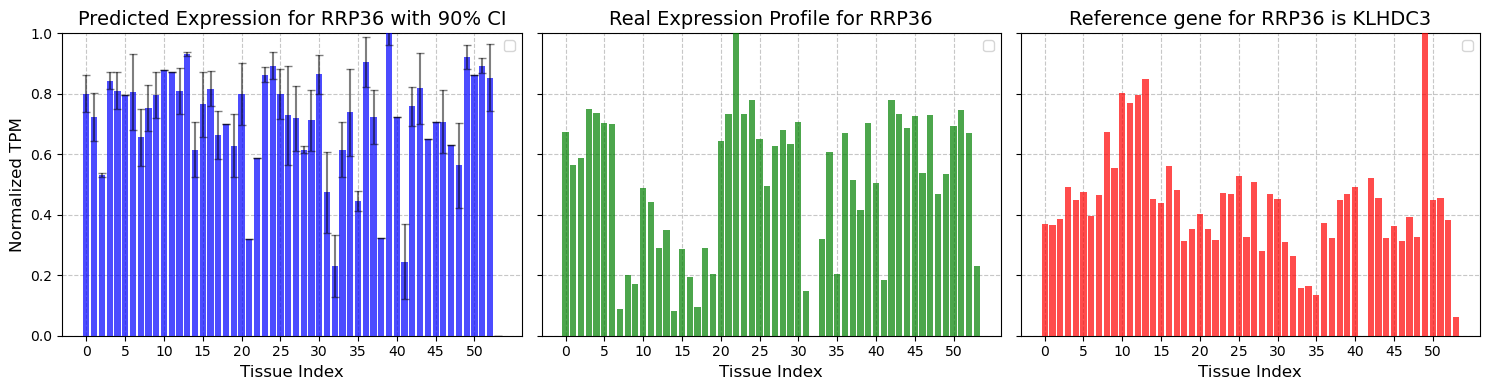

In [ ]:
idx = np.random.randint(0, len(testing_df))
show_random_profile_prediction(idx)

/tmp/ipykernel_1389/1227893923.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=10)
/tmp/ipykernel_1389/1227893923.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=10)
/tmp/ipykernel_1389/1227893923.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(fontsize=10)


PCC = 0.8669217598744904


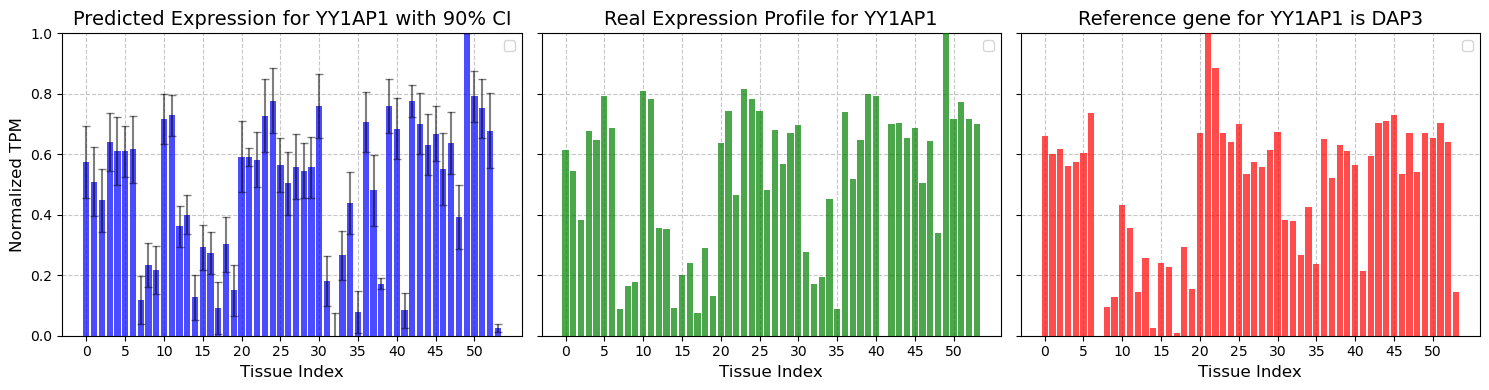

In [ ]:
idx = np.random.randint(0, len(testing_df))
show_random_profile_prediction(idx)

/tmp/ipykernel_1389/1227893923.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=10)
/tmp/ipykernel_1389/1227893923.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=10)
/tmp/ipykernel_1389/1227893923.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(fontsize=10)


PCC = 0.8250408505384886


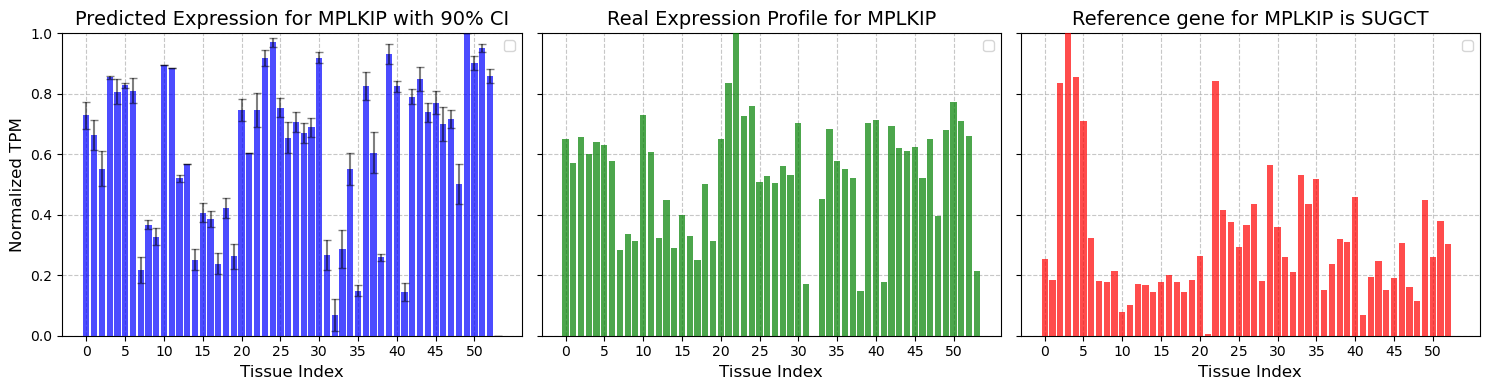

In [ ]:
idx = np.random.randint(0, len(testing_df))
show_random_profile_prediction(idx)

/tmp/ipykernel_1389/1227893923.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=10)
/tmp/ipykernel_1389/1227893923.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=10)
/tmp/ipykernel_1389/1227893923.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(fontsize=10)


PCC = 0.6990675845431457


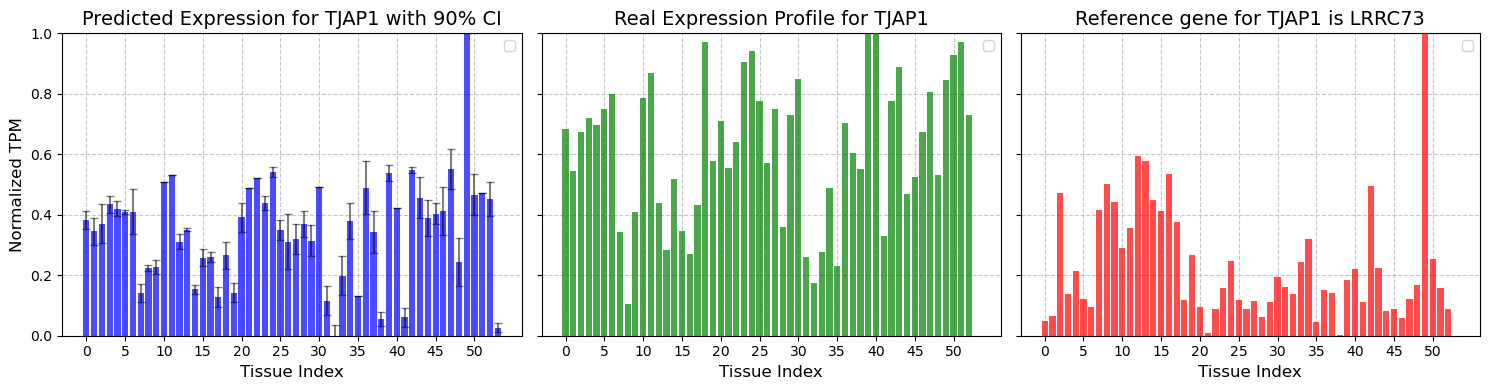

In [ ]:
idx = np.random.randint(0, len(testing_df))
show_random_profile_prediction(idx)

/tmp/ipykernel_1389/1227893923.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=10)
/tmp/ipykernel_1389/1227893923.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=10)
/tmp/ipykernel_1389/1227893923.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(fontsize=10)
/tmp/ipykernel_1389/1227893923.py:94: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  c = pearsonr(pred, real_exp)[0]


PCC = nan


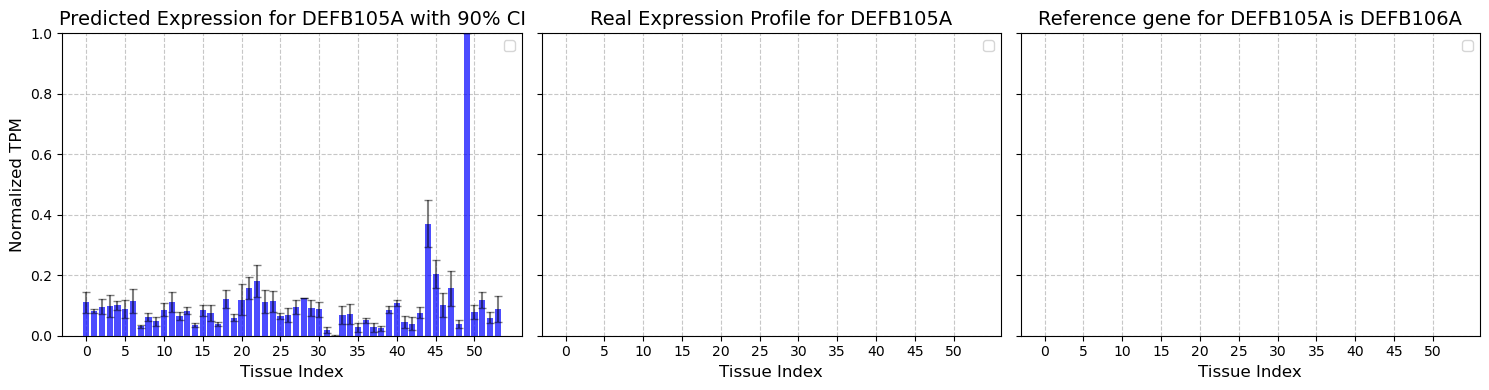

In [ ]:
idx = np.random.randint(0, len(testing_df))
show_random_profile_prediction(idx)
# ref's gene profile is missing, the model make raw prediction by learned features
# distance = 1258
# pcc (non_ref_exp, ref_exp) = nan 
# pcc (pred, real_non_ref) = nan   

In [516]:
print(testing_df[testing_df['non_ref_gene']=='PANK4']['neighbor_dst'])
exp1 = testing_df[testing_df['non_ref_gene']=='PANK4']['ref_exp'].values[0]
exp2 = testing_df[testing_df['non_ref_gene']=='PANK4']['non_ref_exp'].values[0]
pearsonr(exp1,exp2)[0]

16    2148
Name: neighbor_dst, dtype: int64


-0.18977351835190745

/tmp/ipykernel_1389/1227893923.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=10)
/tmp/ipykernel_1389/1227893923.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=10)
/tmp/ipykernel_1389/1227893923.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(fontsize=10)


PCC = 0.7344222947592539


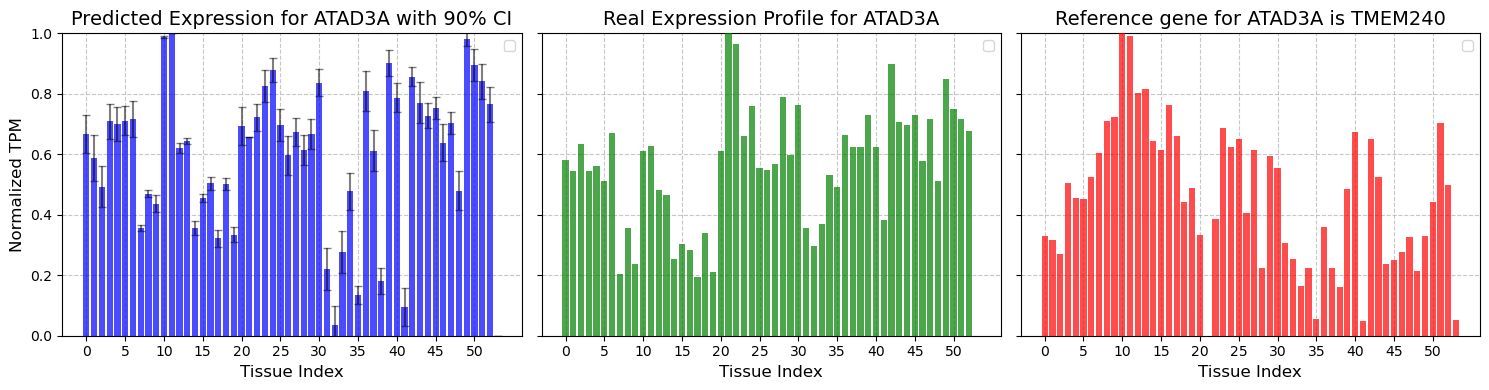

In [ ]:
show_random_profile_prediction(9)
# distance = 92
# pcc (non_ref_exp, ref_exp) = -0.08   -> pcc between neighboring profile (ref and non_ref) = -0.08  -> assume identical
# pcc (pred, real_non_ref) = 0.73   -> pcc between pred and actual non_ref_gene's profile is 0.73

/tmp/ipykernel_1389/1227893923.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=10)
/tmp/ipykernel_1389/1227893923.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=10)
/tmp/ipykernel_1389/1227893923.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(fontsize=10)


PCC = 0.7755225521882328


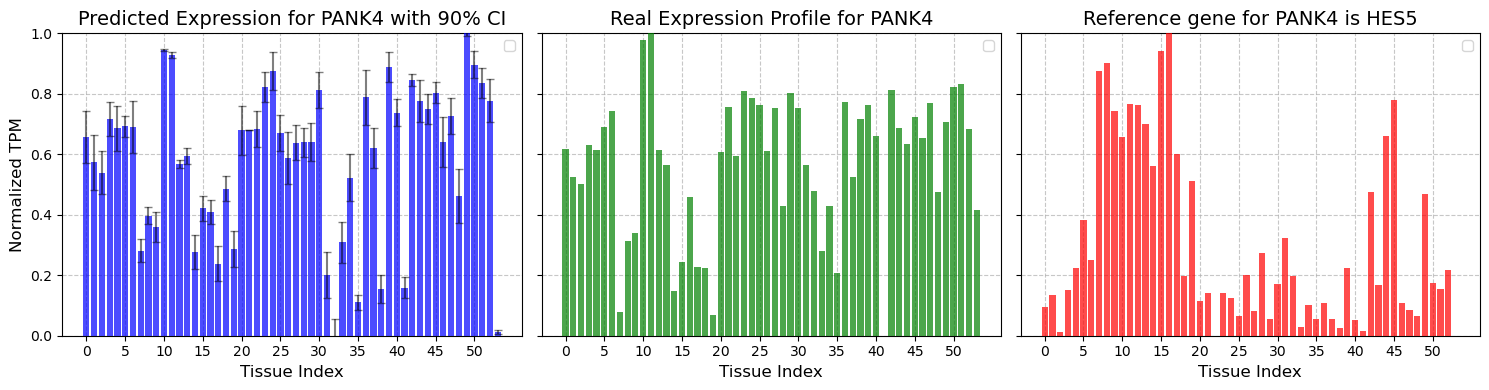

In [ ]:
show_random_profile_prediction(16)
# distance = 2148
# pcc (non_ref_exp, ref_exp) = -0.19   -> pcc between neighboring profile (ref and non_ref) = -0.19  -> assume identical
# pcc (pred, real_non_ref) = 0.77   -> pcc between pred and actual non_ref_gene's profile is 0.77

In [29]:
# --- 1. Extract activations from first Conv1D layer ---
def get_activation_model(cnn_model):
    conv_layer = cnn_model.get_layer(name='conv2')
    return Model(inputs=cnn_model.input, outputs=conv_layer.output)

# --- 2. Extract top-k activating sequences ---
def get_top_activating_sequences(X_onehot, sequences, activations, filter_index, top_k=10, kmer_size=8):
    top_seqs = []

    for i in range(X_onehot.shape[0]):
        act_map = activations[i, :, filter_index]  # shape: sequence length
        max_pos = np.argmax(act_map)
        start = max(0, max_pos - kmer_size // 2)
        end = min(start + kmer_size, len(sequences[i]))
        kmer = sequences[i][start:end].upper()
        score = act_map[max_pos]
        if len(kmer) == kmer_size:  # ensure full length
            top_seqs.append((kmer, score))

    top_seqs.sort(key=lambda x: x[1], reverse=True)
    return [k for k, _ in top_seqs[:top_k]]

# --- 3. Convert top kmers to position frequency matrix (PFM) ---
def build_pfm(seqs):
    kmer_len = len(seqs[0])
    pfm = np.zeros((kmer_len, 4))  # rows=positions, cols=A/C/G/T
    base_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    for seq in seqs:
        for i, base in enumerate(seq):
            if base in base_index:
                pfm[i, base_index[base]] += 1

    return pfm / len(seqs)  # normalize to get PWM (freq matrix)

# --- 4. Plot the PWM using Logomaker ---
def plot_pwm(pwm, filter_index):
    df = pd.DataFrame(pwm, columns=['A', 'C', 'G', 'T'])
    plt.figure(figsize=(10, 2))
    logomaker.Logo(df)
    plt.title(f"Sequence Logo for CNN Filter {filter_index}")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
activation_model = get_activation_model(cnn)

# Get activations from first Conv1D layer
activations = activation_model.predict(X_curr_promoter, batch_size=64)

# Original input sequences
sequences = training_df['current_promoter'].tolist()

num_filters = activations.shape[-1]

for i in range(num_filters):
    # Get top activating 8-mers for filter #0
    top_kmers = get_top_activating_sequences(
        X_onehot=X_curr_promoter,
        sequences=sequences,
        activations=activations,
        filter_index=i, 
        top_k=20,
        kmer_size=33
    )

    if top_kmers:
        # Build and plot PWM
        pwm = build_pfm(top_kmers)
        plot_pwm(pwm, filter_index=i)
    else:
        print(f"No valid kmers for filter {i}")


In [13]:
def pwm_to_meme(pwm, motif_name="CNN_Filter_3"):
    """
    Convert a PWM (position frequency matrix) to MEME format string.
    """
    header = (
        "MEME version 4\n\n"
        "ALPHABET= ACGT\n\n"
        "strands: + -\n\n"
        "Background letter frequencies:\n"
        "A 0.25 C 0.25 G 0.25 T 0.25\n\n"
        f"MOTIF {motif_name}\n"
        f"letter-probability matrix: alength= 4 w= {pwm.shape[0]} nsites= 20 E= 0\n"
    )
    matrix_rows = "\n".join([" ".join([f"{v:.6f}" for v in row]) for row in pwm])
    return header + matrix_rows + "\n"

In [14]:
meme_txt = pwm_to_meme(pwm)
with open("cnn_filter_3.meme", "w") as f:
    f.write(meme_txt)

visualize transformer



In [12]:
custom_objects = {
    'PositionalEncoding': PositionalEncoding,
    'TransformerEncoderLayer': TransformerEncoderLayer
}
model = keras.models.load_model('cnn_encoder.keras', custom_objects=custom_objects)

# Find the transformer layer (adjust name if needed)
transformer_layer = None
for layer in model.layers:
    if isinstance(layer, TransformerEncoderLayer):
        transformer_layer = layer
        break

if transformer_layer is None:
    raise ValueError("TransformerEncoderLayer not found in the model.")

In [26]:
neighbor_exp_array = np.array(training_df['neighbor_exp'].tolist())
X = neighbor_exp_array.reshape(-1, 54, 1).astype(np.float32)  # shape: (14022, 54, 1)

In [14]:
tissue_name = ['Subcutaneous - Adipose', 'Visceral (Omentum) - Adipose',
       'Adrenal Gland', 'Aorta - Artery', 'Coronary - Artery',
       'Tibial - Artery', 'Bladder', 'Amygdala - Brain',
       'Anterior cingulate - Brain', 'Caudate nucleus - Brain',
       'Cerebellar Hemisphere - Brain', 'Cerebellum - Brain', 'Cortex - Brain',
       'Frontal Cortex - Brain', 'Hippocampus - Brain', 'Hypothalamus - Brain',
       'Nucleus accumbens - Brain', 'Putamen - Brain',
       'Spinal cord (C1) - Brain', 'Substantia nigra - Brain',
       'Mammary Tissue - Breast', 'Xform. fibroblasts - Cells', 'EBV-xform lymphocytes - Cells', 
       'Ectocervix - Cervix', 'Endocervix - Cervix', 'Sigmoid - Colon',
       'Transverse - Colon', 'Gastroesoph. Junc. - Esophagus',
       'Mucosa - Esophagus', 'Muscularis - Esophagus', 'Fallopian Tube',
       'Atrial Appendage - Heart', 'Left Ventricle - Heart', 'Cortex - Kidney','Cortex - Medulla',
       'Liver', 'Lung', 'Minor Salivary Gland', 'Skeletal - Muscle',
       'Tibial - Nerve', 'Ovary', 'Pancreas', 'Pituitary', 'Prostate',
       'Not Sun Exposed - Skin', 'Sun Exposed (Lower leg) - Skin',
       'Ileum - Small Intestine', 'Spleen', 'Stomach', 'Testis', 'Thyroid',
       'Uterus', 'Vagina', 'Whole Blood']

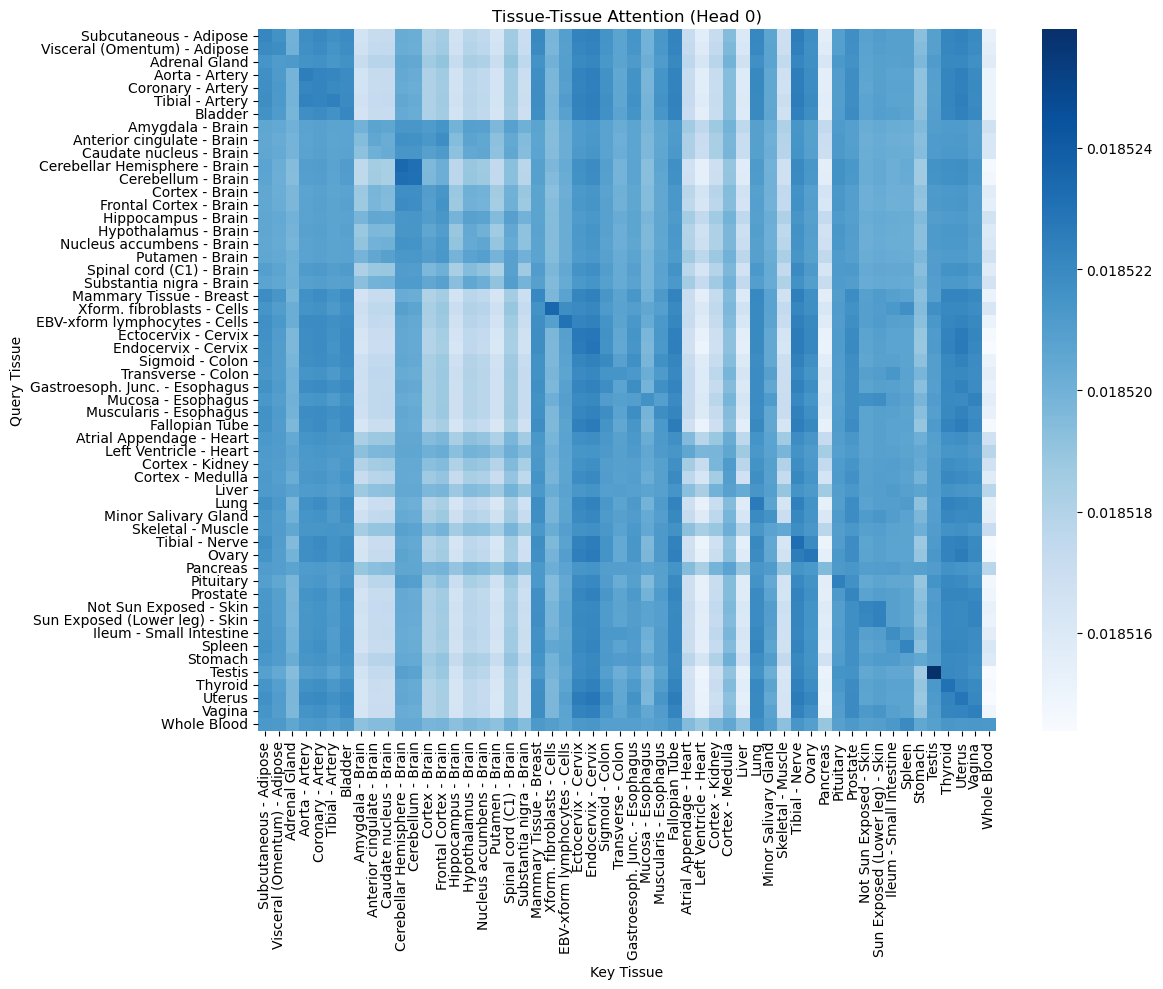

In [33]:
d_model = 128  # must match your TransformerEncoderLayer setup
dense_proj = tf.keras.layers.Dense(d_model)

# Project X to shape (14022, 54, d_model)
X_proj = dense_proj(X)  # shape: (14022, 54, 128)

# Now pass to transformer
_ = transformer_layer(X_proj, training=False)

# Extract attention scores: shape (1, num_heads, 54, 54)
attn_scores_all = transformer_layer.attention_scores.numpy()  # shape: (num_heads, 54, 54)
attn_scores_mean = attn_scores_all.mean(axis=0)  # shape: (num_heads, 54, 54)


# Visualize attention from one head (e.g., head 0)
# Custom blue-to-white colormap (low=blue, high=white)
#skyblue_white = LinearSegmentedColormap.from_list("skyblue_white", ["#052F6A", "#F3F9FE"])

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(attn_scores_mean[5], cmap='Blues', xticklabels=tissue_name, yticklabels=tissue_name)

plt.title("Tissue-Tissue Attention (Head 0)")
plt.xlabel("Key Tissue")
plt.ylabel("Query Tissue")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

visualize xgb

Feature Group Importance (%):
CNN: 47.51%
Distance: 28.04%
Orientation: 12.84%
Transformer: 11.61%


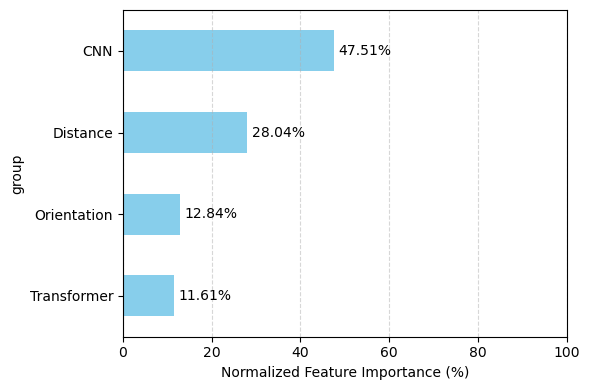

In [520]:
# --- Step 1: Get feature names ---
strand_encoder = aux_preprocessor.named_transformers_['strand']
strand_feature_names = strand_encoder.get_feature_names_out(['current_strand', 'neighbor_strand'])
aux_feature_names = ['aux_distance'] + [f'aux_{name}' for name in strand_feature_names]

tf_feature_names = [f"tf_{i}" for i in range(128)]
cnn_feature_names = [f"cnn_{i}" for i in range(128)]
full_feature_names = tf_feature_names + cnn_feature_names + aux_feature_names

# --- Step 2: Define feature group mapping with distance separated from orientation ---
feature_labels = {
    **{f"cnn_{i}": "CNN" for i in range(128)},
    **{f"tf_{i}": "Transformer" for i in range(128)},
    'aux_distance': 'Distance',
    'aux_current_strand_+': 'Orientation',
    'aux_current_strand_-': 'Orientation',
    'aux_neighbor_strand_+': 'Orientation',
    'aux_neighbor_strand_-': 'Orientation'
}
feature_groups = [feature_labels.get(f, 'Orientation') for f in full_feature_names]

# --- Step 3: Compute SHAP values for one model output (e.g., tissue 0) ---
explainer = shap.Explainer(best_model.estimators_[0])
shap_values = explainer(X_test_features)

# --- Step 4: Aggregate SHAP values with normalization by group size ---
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': full_feature_names,
    'shap_value': mean_abs_shap,
    'group': feature_groups
})

# Count the number of features in each group
group_sizes = shap_df['group'].value_counts()

# Aggregate SHAP values by group and normalize by group size
grouped_shap = shap_df.groupby('group')['shap_value'].sum()
grouped_shap_normalized = grouped_shap / group_sizes  # Normalize by number of features in each group


# Convert to percentage
total_shap = grouped_shap_normalized.sum()
grouped_shap_percent = (grouped_shap_normalized / total_shap) * 100

# Print exact values
print("Feature Group Importance (%):")
for group, value in grouped_shap_percent.items():
    print(f"{group}: {value:.2f}%")

# Plot with exact values
plt.figure(figsize=(6, 4))
bars = grouped_shap_percent.plot(kind='barh', color='skyblue')
plt.xlabel('Normalized Feature Importance (%)')
plt.xlim(0, 100)
plt.gca().invert_yaxis()  # Highest contributor on top
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add text labels to each bar
for i, (value, name) in enumerate(zip(grouped_shap_percent, grouped_shap_percent.index)):
    plt.text(value + 1, i, f'{value:.2f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()